In [43]:
"""
# Normalizing Flows Implementation Guide

## Introduction
Normalizing flows are a class of generative models that learn complex probability distributions 
by transforming a simple base distribution through a sequence of invertible mappings.

## Key Concepts

### 1. Change of Variables Formula
The fundamental principle behind normalizing flows is the change of variables formula:
p_x(x) = p_z(z) * |det(dz/dx)|
where:
- p_x(x) is the target distribution
- p_z(z) is the base distribution (usually standard normal)
- |det(dz/dx)| is the absolute determinant of the Jacobian

### 2. Flow Types
Different flow architectures provide different ways to transform the data while maintaining
invertibility and tractable Jacobian determinants:
- Planar: Uses planar transformations (f(z) = z + u*h(w^T*z + b))
- Radial: Uses radial transformations around a learned reference point
- RealNVP: Uses affine coupling layers with masked transformations
- MAF: Uses autoregressive transformations for increased flexibility
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import Normal


In [44]:
def create_toy_dataset(n_samples=1000, dataset_type='two_gaussians'):
    """
    Creates various 2D toy datasets
    """
    if dataset_type == 'two_gaussians':
        z = np.random.randn(n_samples, 2) * 0.5
        z[:n_samples//2, 0] += 2
        z[n_samples//2:, 0] -= 2
    elif dataset_type == 'circles':
        r = np.random.normal(1, 0.1, n_samples)
        theta = np.random.uniform(0, 2*np.pi, n_samples)
        z = np.stack([r*np.cos(theta), r*np.sin(theta)], axis=1)
    elif dataset_type == 'moons':
        t = np.random.uniform(0, np.pi, n_samples)
        x = np.cos(t)
        y = np.sin(t)
        z1 = np.stack([x, y], axis=1)
        z2 = np.stack([x+1, y-1], axis=1)
        z = np.vstack([z1[:n_samples//2], z2[n_samples//2:]])
        z += np.random.normal(0, 0.1, z.shape)
    
    return torch.FloatTensor(z)

In [45]:
class PlanarFlow(nn.Module):
    """
    Planar flow with fixed log determinant shape
    """
    def __init__(self, dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim))
        self.u = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        activation = torch.tanh(F.linear(z, self.w, self.b))
        return z + self.u * activation
    
    def log_det_jacobian(self, z):
        activation = torch.tanh(F.linear(z, self.w, self.b))
        psi = (1 - activation**2) * self.w
        det = 1 + torch.matmul(psi, self.u.T)
        # Ensure output shape is [batch_size]
        return torch.log(torch.abs(det)).squeeze(-1)

class RadialFlow(nn.Module):
    """
    Radial flow: f(z) = z + β h(α,r)(z-z_0)
    where r is the distance from z_0 and h(α,r) = 1/(α + r)
    """
    def __init__(self, dim):
        super().__init__()
        self.z0 = nn.Parameter(torch.randn(1, dim))
        self.log_alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (alpha + r)
        return z + self.beta * h * (z - self.z0)
    
    def log_det_jacobian(self, z):
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (alpha + r)
        h_prime = -1 / (alpha + r)**2
        det = (1 + self.beta * h + self.beta * h_prime * r)**(z.shape[1] - 1)
        det *= (1 + self.beta * h)
        # Ensure output shape is [batch_size]
        return torch.log(torch.abs(det)).squeeze(-1)

class RealNVPCoupling(nn.Module):
    """
    Real NVP coupling layer
    Reference: https://arxiv.org/abs/1605.08803
    """
    def __init__(self, dim, hidden_dim=64, mask_type='alternate'):
        super().__init__()
        self.dim = dim
        
        # Create mask
        self.mask = torch.ones(dim)
        if mask_type == 'alternate':
            self.mask[::2] = 0
        elif mask_type == 'half':
            self.mask[:dim//2] = 0
            
        # Scale and translation networks
        self.s_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()
        )
        
        self.t_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        
    def forward(self, z):
        masked_z = z * self.mask
        s = self.s_network(masked_z) * (1 - self.mask)
        t = self.t_network(masked_z) * (1 - self.mask)
        
        # Scale and shift
        exp_s = torch.exp(s)
        transformed = z * self.mask + (1 - self.mask) * (z * exp_s + t)
        log_det = torch.sum(s * (1 - self.mask), dim=1)
        
        return transformed, log_det

class MAF(nn.Module):
    """
    Masked Autoregressive Flow
    Reference: https://arxiv.org/abs/1705.07057
    """
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        self.dim = dim
        
        # Create MADE-like network
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * dim)  # Output both μ and log_σ
        )
        
        # Create autoregressive mask
        self.register_buffer('mask', self._create_mask())
        
    def _create_mask(self):
        # Create a lower triangular mask
        mask = torch.tril(torch.ones(self.dim, self.dim), -1)
        return mask
    
    def forward(self, z):
        batch_size = z.size(0)
        
        # Get parameters from network
        net_out = self.net(z)
        mu, log_sigma = net_out.chunk(2, dim=1)
        
        # Reshape mask for broadcasting
        mask = self.mask.unsqueeze(0)  # [1, dim, dim]
        
        # Apply mask to ensure autoregressive property
        # Compute masked mu: [batch_size, dim]
        masked_mu = torch.bmm(mask.expand(batch_size, -1, -1), 
                            z.unsqueeze(2)).squeeze(2)
        
        # Transform
        sigma = torch.exp(log_sigma)
        transformed = (z - masked_mu) / sigma
        log_det = -torch.sum(log_sigma, dim=1)
        
        return transformed, log_det


In [46]:
class NormalizingFlow(nn.Module):
    """
    A sequence of normalizing flows with proper log determinant handling
    """
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        
    def forward(self, z):
        log_det_sum = torch.zeros(z.size(0), device=z.device)
        
        for flow in self.flows:
            if isinstance(flow, (RealNVPCoupling, MAF)):
                z, log_det = flow(z)
            else:
                log_det = flow.log_det_jacobian(z)
                z = flow(z)
                
            # Ensure log_det has correct shape [batch_size]
            if log_det.dim() > 1:
                log_det = log_det.sum(1)
            elif log_det.dim() == 0:
                log_det = log_det.expand(z.size(0))
                
            log_det_sum += log_det
            
        return z, log_det_sum



In [55]:
def visualize_flow(flow, data, n_samples=1000):
    """
    Create comprehensive visualizations of the flow with improved numerical stability
    """
    with torch.no_grad():
        # Generate samples
        z = torch.randn(n_samples, 2)
        samples, _ = flow(z)
        
        # Clip extreme values
        samples = torch.clamp(samples, -10, 10)
        
        samples = samples.numpy()
        z = z.numpy()
        data = data.numpy()
    
    # Function to safely compute histogram
    def safe_histogram2d(x, y, bins=50):
        # Remove any infinite or NaN values
        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]
        
        # Compute reasonable bounds
        x_min, x_max = np.percentile(x, [1, 99])
        y_min, y_max = np.percentile(y, [1, 99])
        
        range_tuple = [[x_min, x_max], [y_min, y_max]]
        return np.histogram2d(x, y, bins=bins, range=range_tuple, density=True)
    
    fig = plt.figure(figsize=(15, 10))
    
    # Original distribution
    plt.subplot(231)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(data[:, 0], data[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Original Distribution')
    
    # Base distribution
    plt.subplot(232)
    plt.scatter(z[:, 0], z[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(z[:, 0], z[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Base Distribution (Normal)')
    
    # Generated distribution
    plt.subplot(233)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(samples[:, 0], samples[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Generated Distribution')
    
    # Histograms with safe ranges
    plt.subplot(234)
    h, xedges, yedges = safe_histogram2d(data[:, 0], data[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Original Distribution (2D Histogram)')
    
    plt.subplot(235)
    h, xedges, yedges = safe_histogram2d(z[:, 0], z[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Base Distribution (2D Histogram)')
    
    plt.subplot(236)
    h, xedges, yedges = safe_histogram2d(samples[:, 0], samples[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Generated Distribution (2D Histogram)')
    
    plt.tight_layout()
    return fig

def train_flow(flow, data, n_epochs=1000, lr=1e-4):
    """
    Train the normalizing flow with improved numerical stability
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        try:
            # Forward pass through flow
            z, log_det = flow(data)
            
            # Clip extreme values
            z = torch.clamp(z, -10, 10)
            log_det = torch.clamp(log_det, -100, 100)
            
            # Compute loss (negative log likelihood)
            prior_ll = -0.5 * (z**2).sum(1) - 0.5 * np.log(2*np.pi) * z.shape[1]
            loss = -(prior_ll + log_det).mean()
            
            # Check for invalid values
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss value at epoch {epoch+1}")
                continue
            
            # Clip loss for stability
            loss = torch.clamp(loss, -1e6, 1e6)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients for stability
            torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Add parameter constraints after optimization step
            with torch.no_grad():
                for param in flow.parameters():
                    param.data.clamp_(-10, 10)
            
            losses.append(loss.item())
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')
                
        except RuntimeError as e:
            print(f"Error at epoch {epoch+1}: {str(e)}")
            continue
    
    return flow, losses


Training on two_gaussians dataset:

Training Simple architecture...
Epoch 100/3000, Loss: 6.3442
Epoch 200/3000, Loss: 6.2534
Epoch 300/3000, Loss: 6.1635
Epoch 400/3000, Loss: 6.0746
Epoch 500/3000, Loss: 5.9866
Epoch 600/3000, Loss: 5.8996
Epoch 700/3000, Loss: 5.8138
Epoch 800/3000, Loss: 5.7291
Epoch 900/3000, Loss: 5.6455
Epoch 1000/3000, Loss: 5.5633
Epoch 1100/3000, Loss: 5.4824
Epoch 1200/3000, Loss: 5.4028
Epoch 1300/3000, Loss: 5.3248
Epoch 1400/3000, Loss: 5.2483
Epoch 1500/3000, Loss: 5.1733
Epoch 1600/3000, Loss: 5.1001
Epoch 1700/3000, Loss: 5.0287
Epoch 1800/3000, Loss: 4.9592
Epoch 1900/3000, Loss: 4.8921
Epoch 2000/3000, Loss: 4.8338
Epoch 2100/3000, Loss: 4.7820
Epoch 2200/3000, Loss: 4.7328
Epoch 2300/3000, Loss: 4.6879
Epoch 2400/3000, Loss: 4.6450
Epoch 2500/3000, Loss: 4.6040
Epoch 2600/3000, Loss: 4.5643
Epoch 2700/3000, Loss: 4.5253
Epoch 2800/3000, Loss: 4.4869
Epoch 2900/3000, Loss: 4.4489
Epoch 3000/3000, Loss: 4.4112


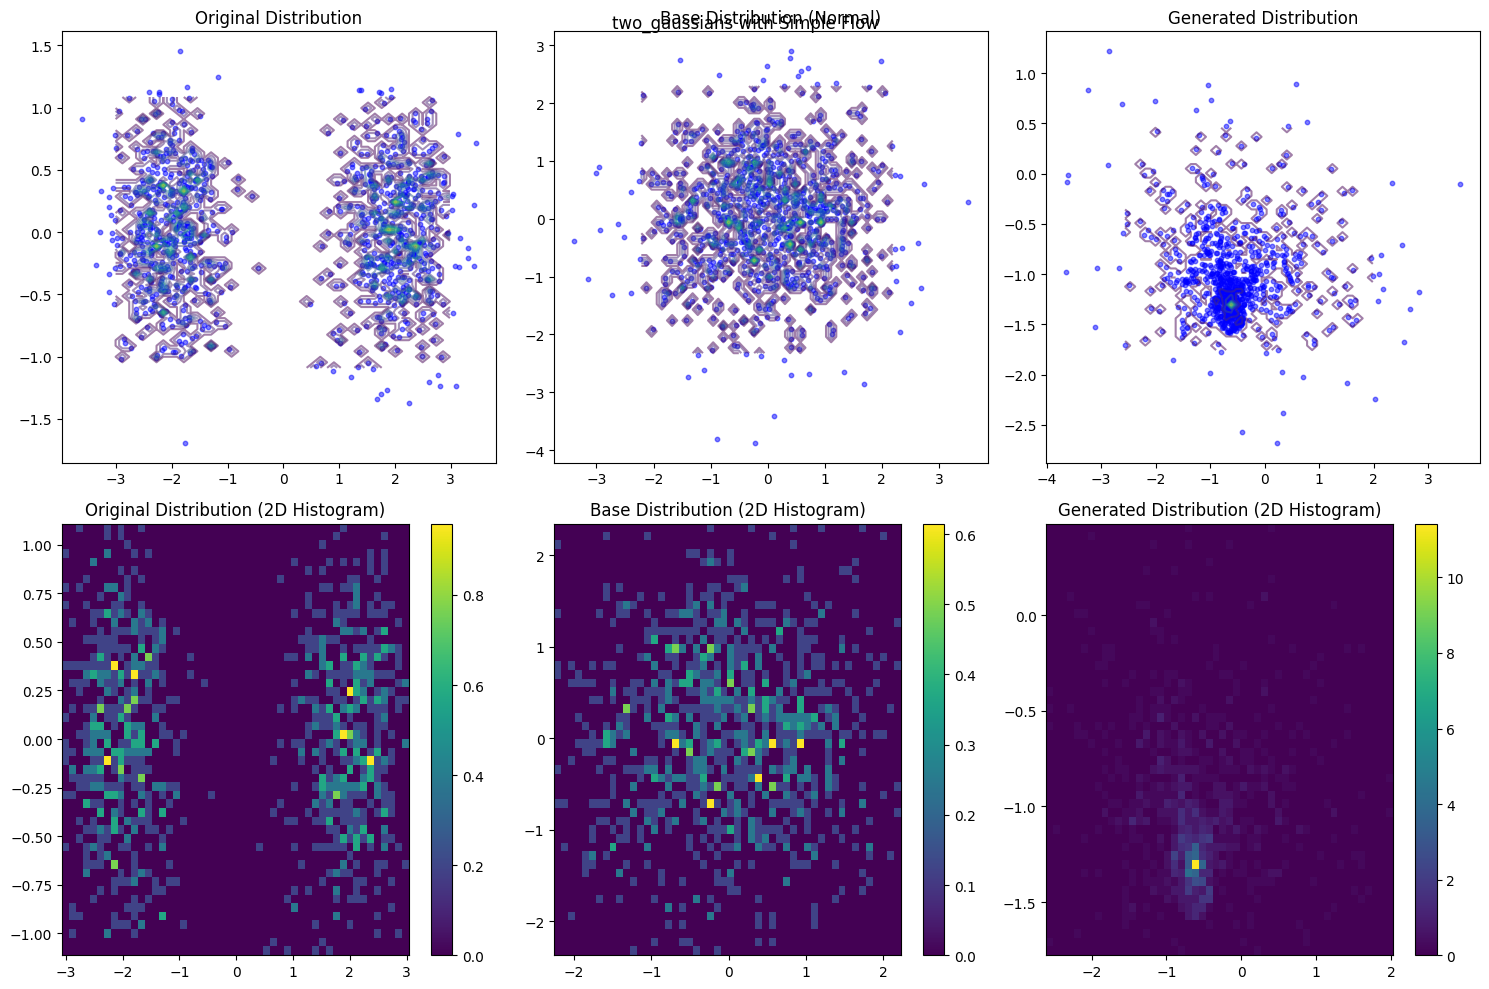

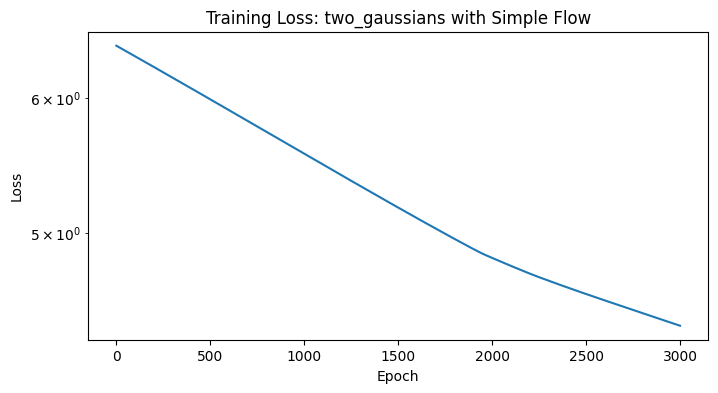


Training RealNVP architecture...
Epoch 100/3000, Loss: 3.1957
Epoch 200/3000, Loss: 3.1926
Epoch 300/3000, Loss: 3.1912
Epoch 400/3000, Loss: 3.1898
Epoch 500/3000, Loss: 3.1885
Epoch 600/3000, Loss: 3.1873
Epoch 700/3000, Loss: 3.1862
Epoch 800/3000, Loss: 3.1849
Epoch 900/3000, Loss: 3.1835
Epoch 1000/3000, Loss: 3.1818
Epoch 1100/3000, Loss: 3.1801
Epoch 1200/3000, Loss: 3.1784
Epoch 1300/3000, Loss: 3.1767
Epoch 1400/3000, Loss: 3.1751
Epoch 1500/3000, Loss: 3.1736
Epoch 1600/3000, Loss: 3.1722
Epoch 1700/3000, Loss: 3.1708
Epoch 1800/3000, Loss: 3.1695
Epoch 1900/3000, Loss: 3.1682
Epoch 2000/3000, Loss: 3.1670
Epoch 2100/3000, Loss: 3.1659
Epoch 2200/3000, Loss: 3.1648
Epoch 2300/3000, Loss: 3.1639
Epoch 2400/3000, Loss: 3.1631
Epoch 2500/3000, Loss: 3.1625
Epoch 2600/3000, Loss: 3.1618
Epoch 2700/3000, Loss: 3.1614
Epoch 2800/3000, Loss: 3.1608
Epoch 2900/3000, Loss: 3.1604
Epoch 3000/3000, Loss: 3.1600


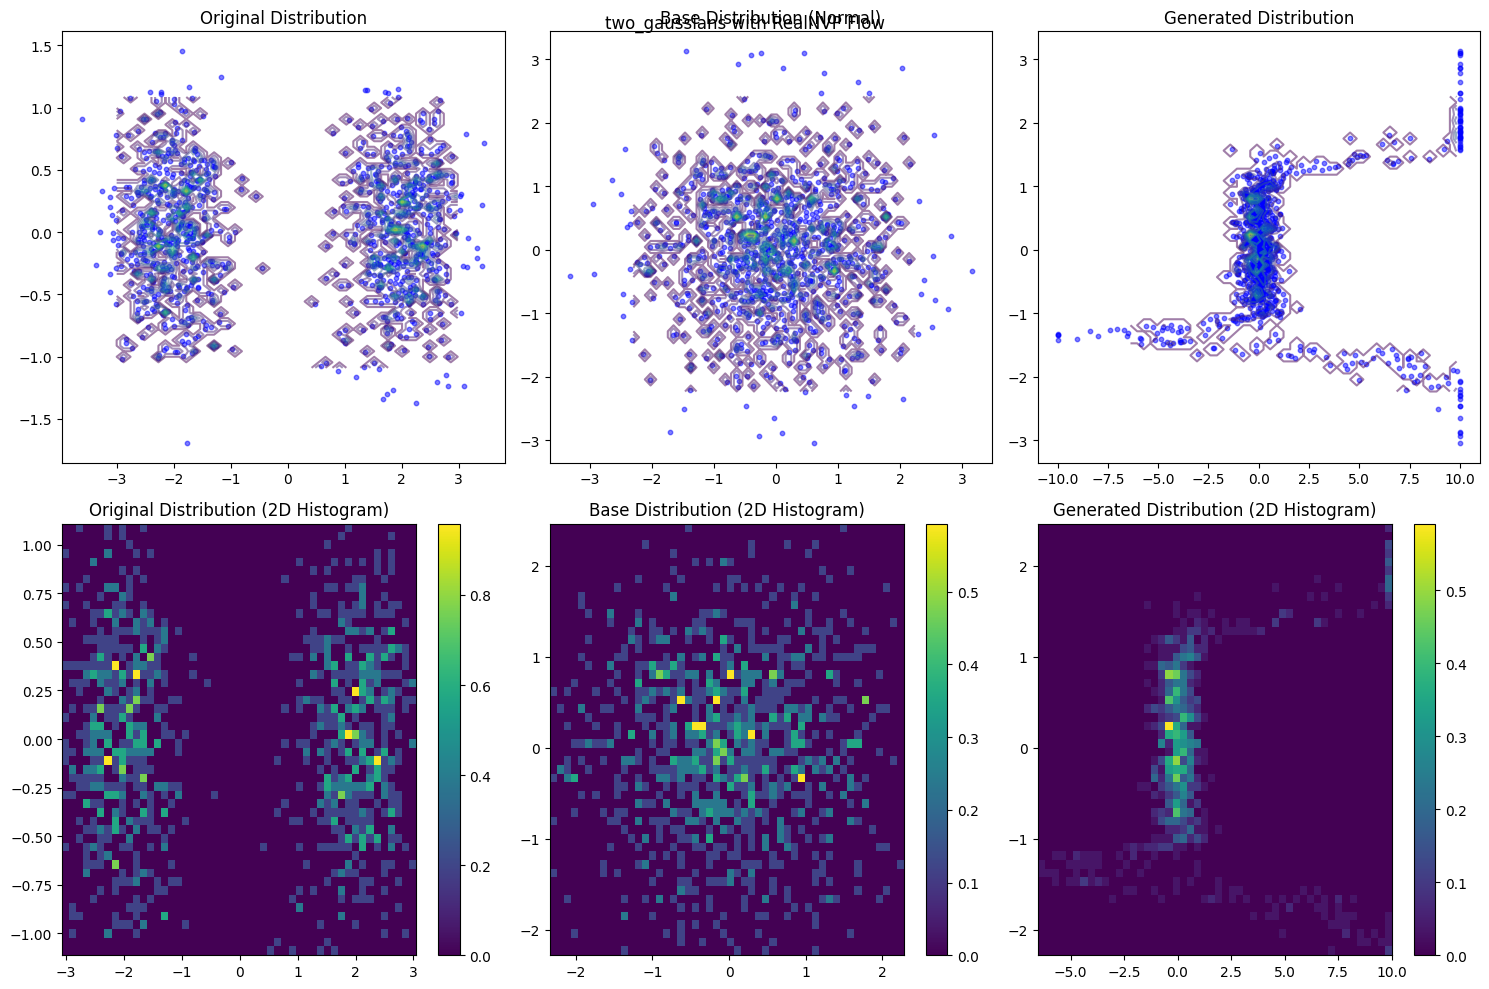

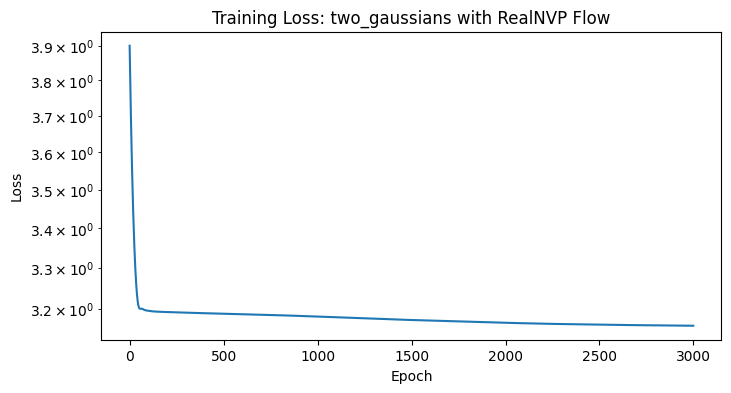


Training MAF architecture...
Epoch 100/3000, Loss: 4.6618
Epoch 200/3000, Loss: 4.3059
Epoch 300/3000, Loss: 4.2308
Epoch 400/3000, Loss: 4.1971
Epoch 500/3000, Loss: 4.1774
Epoch 600/3000, Loss: 4.1680
Epoch 700/3000, Loss: 4.1621
Epoch 800/3000, Loss: 4.1578
Epoch 900/3000, Loss: 4.1546
Epoch 1000/3000, Loss: 4.1531
Epoch 1100/3000, Loss: 4.1525
Epoch 1200/3000, Loss: 4.1493
Epoch 1300/3000, Loss: 4.1485
Epoch 1400/3000, Loss: 4.1484
Epoch 1500/3000, Loss: 4.1473
Epoch 1600/3000, Loss: 4.1460
Epoch 1700/3000, Loss: 4.1454
Epoch 1800/3000, Loss: 4.1444
Epoch 1900/3000, Loss: 4.1437
Epoch 2000/3000, Loss: 4.1432
Epoch 2100/3000, Loss: 4.1430
Epoch 2200/3000, Loss: 4.1424
Epoch 2300/3000, Loss: 4.1419
Epoch 2400/3000, Loss: 4.1414
Epoch 2500/3000, Loss: 4.1413
Epoch 2600/3000, Loss: 4.1410
Epoch 2700/3000, Loss: 4.1403
Epoch 2800/3000, Loss: 4.1402
Epoch 2900/3000, Loss: 4.1400
Epoch 3000/3000, Loss: 4.1397


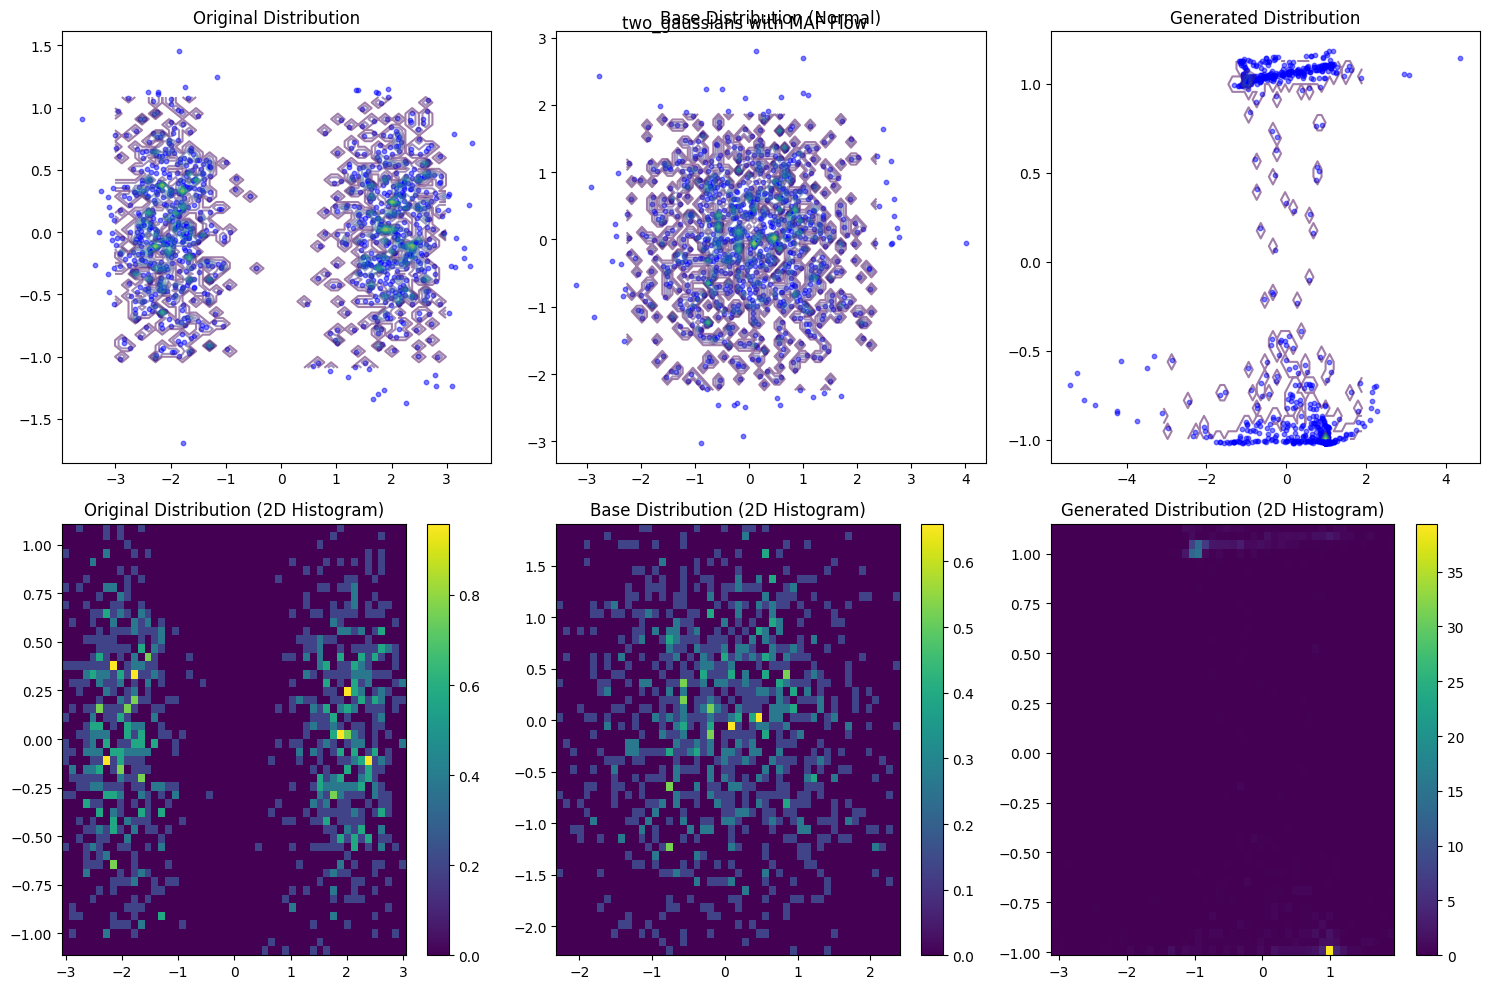

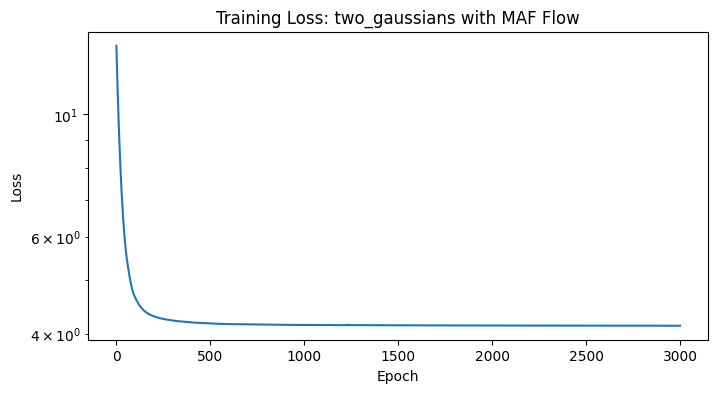


Training Mixed architecture...
Epoch 100/3000, Loss: 2.1307
Epoch 200/3000, Loss: 1.8352
Epoch 300/3000, Loss: 1.6146
Epoch 400/3000, Loss: 1.4379
Epoch 500/3000, Loss: 1.3087
Epoch 600/3000, Loss: 1.2106
Epoch 700/3000, Loss: 1.1289
Epoch 800/3000, Loss: 1.0608
Epoch 900/3000, Loss: 1.0007
Epoch 1000/3000, Loss: 0.9462
Epoch 1100/3000, Loss: 0.8960
Epoch 1200/3000, Loss: 0.8491
Epoch 1300/3000, Loss: 0.8046
Epoch 1400/3000, Loss: 0.7633
Epoch 1500/3000, Loss: 0.7247
Epoch 1600/3000, Loss: 0.6898
Epoch 1700/3000, Loss: 0.6580
Epoch 1800/3000, Loss: 0.6282
Epoch 1900/3000, Loss: 0.5993
Epoch 2000/3000, Loss: 0.5700
Epoch 2100/3000, Loss: 0.5412
Epoch 2200/3000, Loss: 0.5149
Epoch 2300/3000, Loss: 0.4901
Epoch 2400/3000, Loss: 0.4670
Epoch 2500/3000, Loss: 0.4463
Epoch 2600/3000, Loss: 0.4267
Epoch 2700/3000, Loss: 0.4087
Epoch 2800/3000, Loss: 0.3902
Epoch 2900/3000, Loss: 0.3701
Epoch 3000/3000, Loss: 0.3486


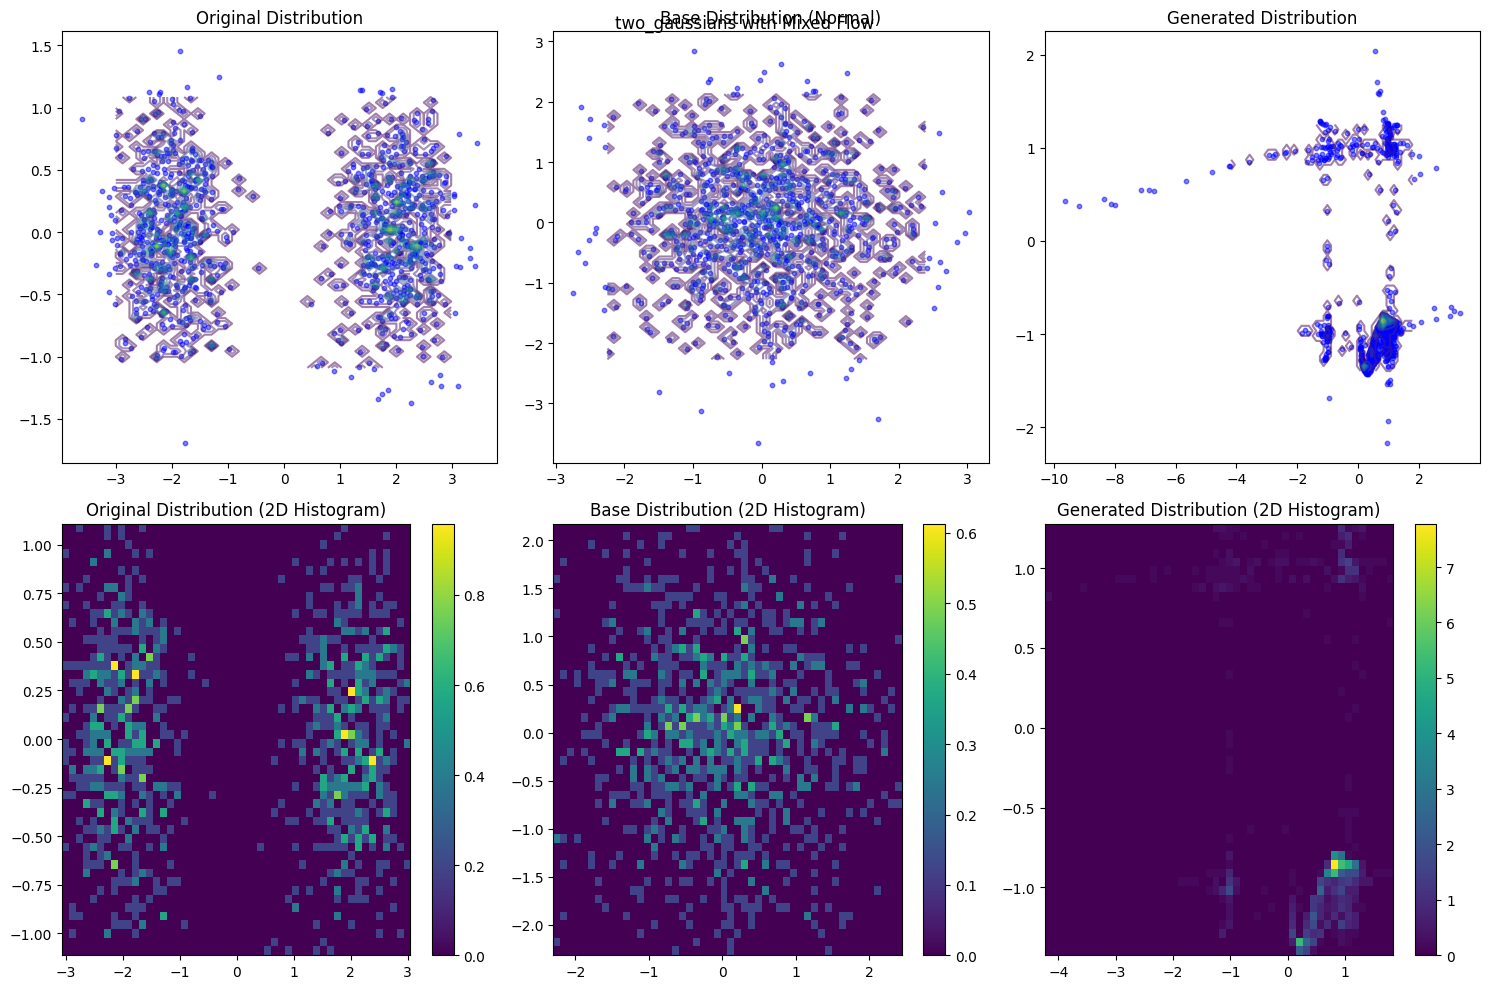

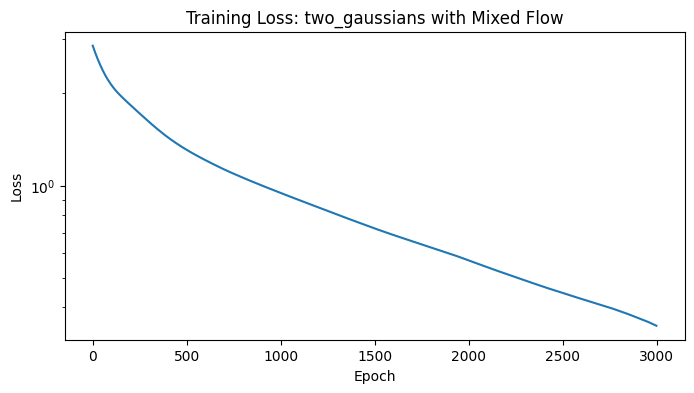


Training on circles dataset:

Training Simple architecture...
Epoch 100/3000, Loss: 4.1639
Epoch 200/3000, Loss: 4.1097
Epoch 300/3000, Loss: 4.0614
Epoch 400/3000, Loss: 4.0169
Epoch 500/3000, Loss: 3.9748
Epoch 600/3000, Loss: 3.9344
Epoch 700/3000, Loss: 3.8955
Epoch 800/3000, Loss: 3.8579
Epoch 900/3000, Loss: 3.8215
Epoch 1000/3000, Loss: 3.7863
Epoch 1100/3000, Loss: 3.7521
Epoch 1200/3000, Loss: 3.7188
Epoch 1300/3000, Loss: 3.6866
Epoch 1400/3000, Loss: 3.6554
Epoch 1500/3000, Loss: 3.6254
Epoch 1600/3000, Loss: 3.5968
Epoch 1700/3000, Loss: 3.5786
Epoch 1800/3000, Loss: 3.5664
Epoch 1900/3000, Loss: 3.5548
Epoch 2000/3000, Loss: 3.5459
Epoch 2100/3000, Loss: 3.5369
Epoch 2200/3000, Loss: 3.5278
Epoch 2300/3000, Loss: 3.5183
Epoch 2400/3000, Loss: 3.5084
Epoch 2500/3000, Loss: 3.4982
Epoch 2600/3000, Loss: 3.4875
Epoch 2700/3000, Loss: 3.4764
Epoch 2800/3000, Loss: 3.4647
Epoch 2900/3000, Loss: 3.4525
Epoch 3000/3000, Loss: 3.4396


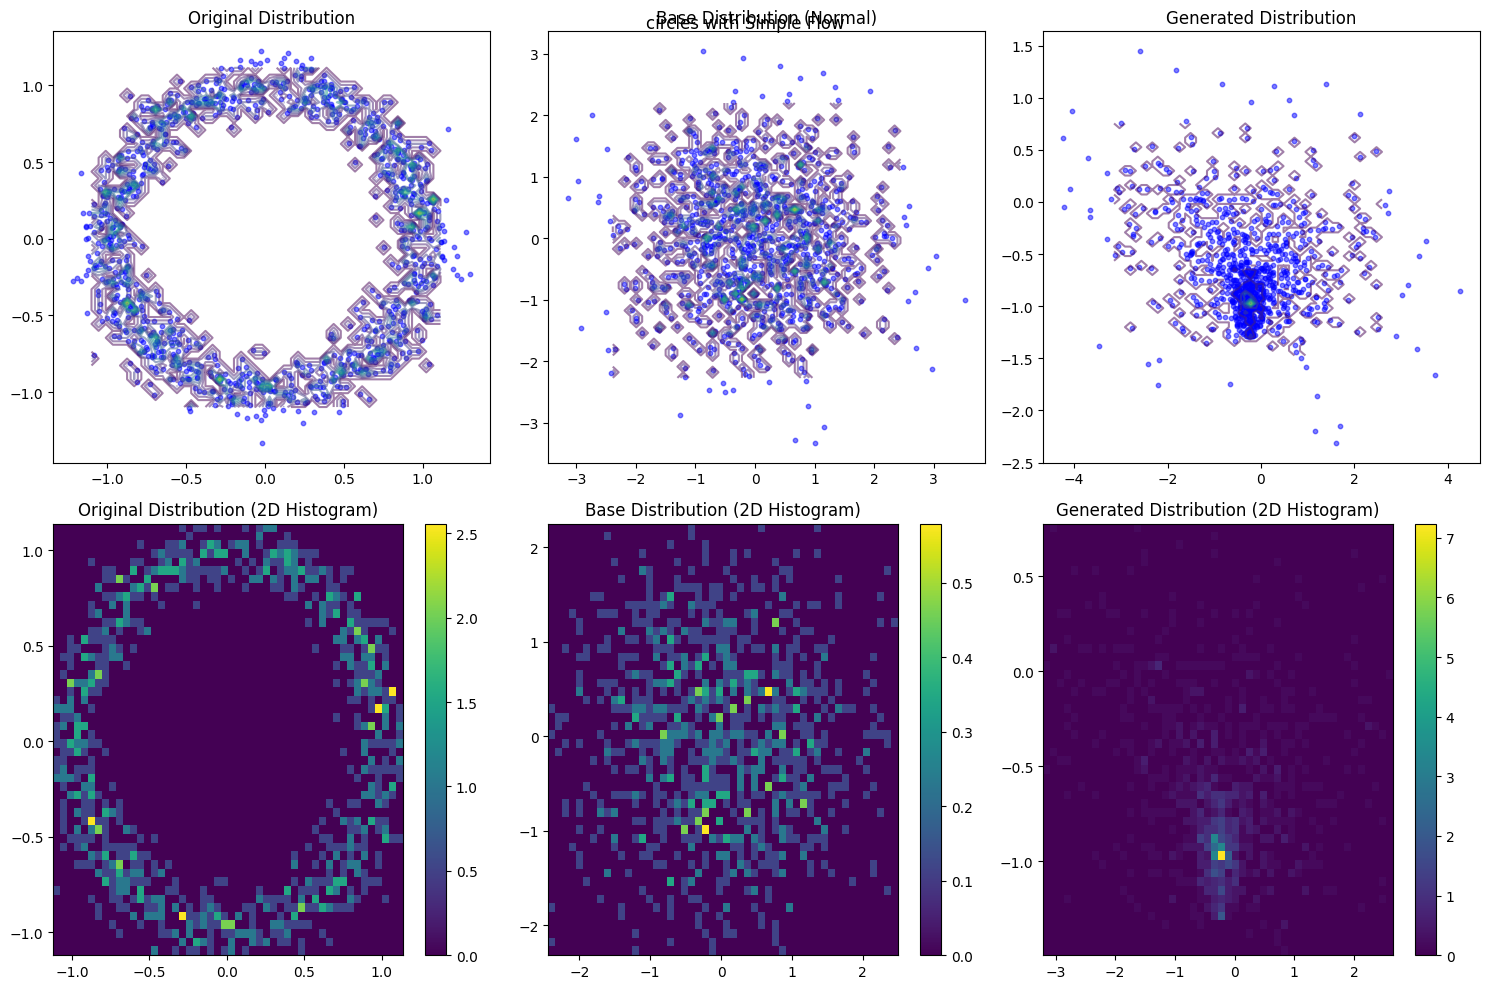

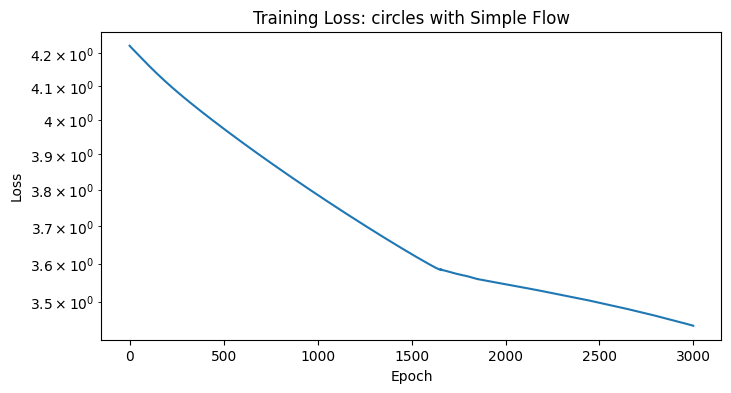


Training RealNVP architecture...
Epoch 100/3000, Loss: 2.1318
Epoch 200/3000, Loss: 2.0922
Epoch 300/3000, Loss: 2.0868
Epoch 400/3000, Loss: 2.0847
Epoch 500/3000, Loss: 2.0834
Epoch 600/3000, Loss: 2.0824
Epoch 700/3000, Loss: 2.0817
Epoch 800/3000, Loss: 2.0812
Epoch 900/3000, Loss: 2.0808
Epoch 1000/3000, Loss: 2.0804
Epoch 1100/3000, Loss: 2.0800
Epoch 1200/3000, Loss: 2.0797
Epoch 1300/3000, Loss: 2.0795
Epoch 1400/3000, Loss: 2.0793
Epoch 1500/3000, Loss: 2.0791
Epoch 1600/3000, Loss: 2.0788
Epoch 1700/3000, Loss: 2.0786
Epoch 1800/3000, Loss: 2.0785
Epoch 1900/3000, Loss: 2.0783
Epoch 2000/3000, Loss: 2.0781
Epoch 2100/3000, Loss: 2.0779
Epoch 2200/3000, Loss: 2.0778
Epoch 2300/3000, Loss: 2.0776
Epoch 2400/3000, Loss: 2.0775
Epoch 2500/3000, Loss: 2.0774
Epoch 2600/3000, Loss: 2.0772
Epoch 2700/3000, Loss: 2.0770
Epoch 2800/3000, Loss: 2.0769
Epoch 2900/3000, Loss: 2.0767
Epoch 3000/3000, Loss: 2.0766


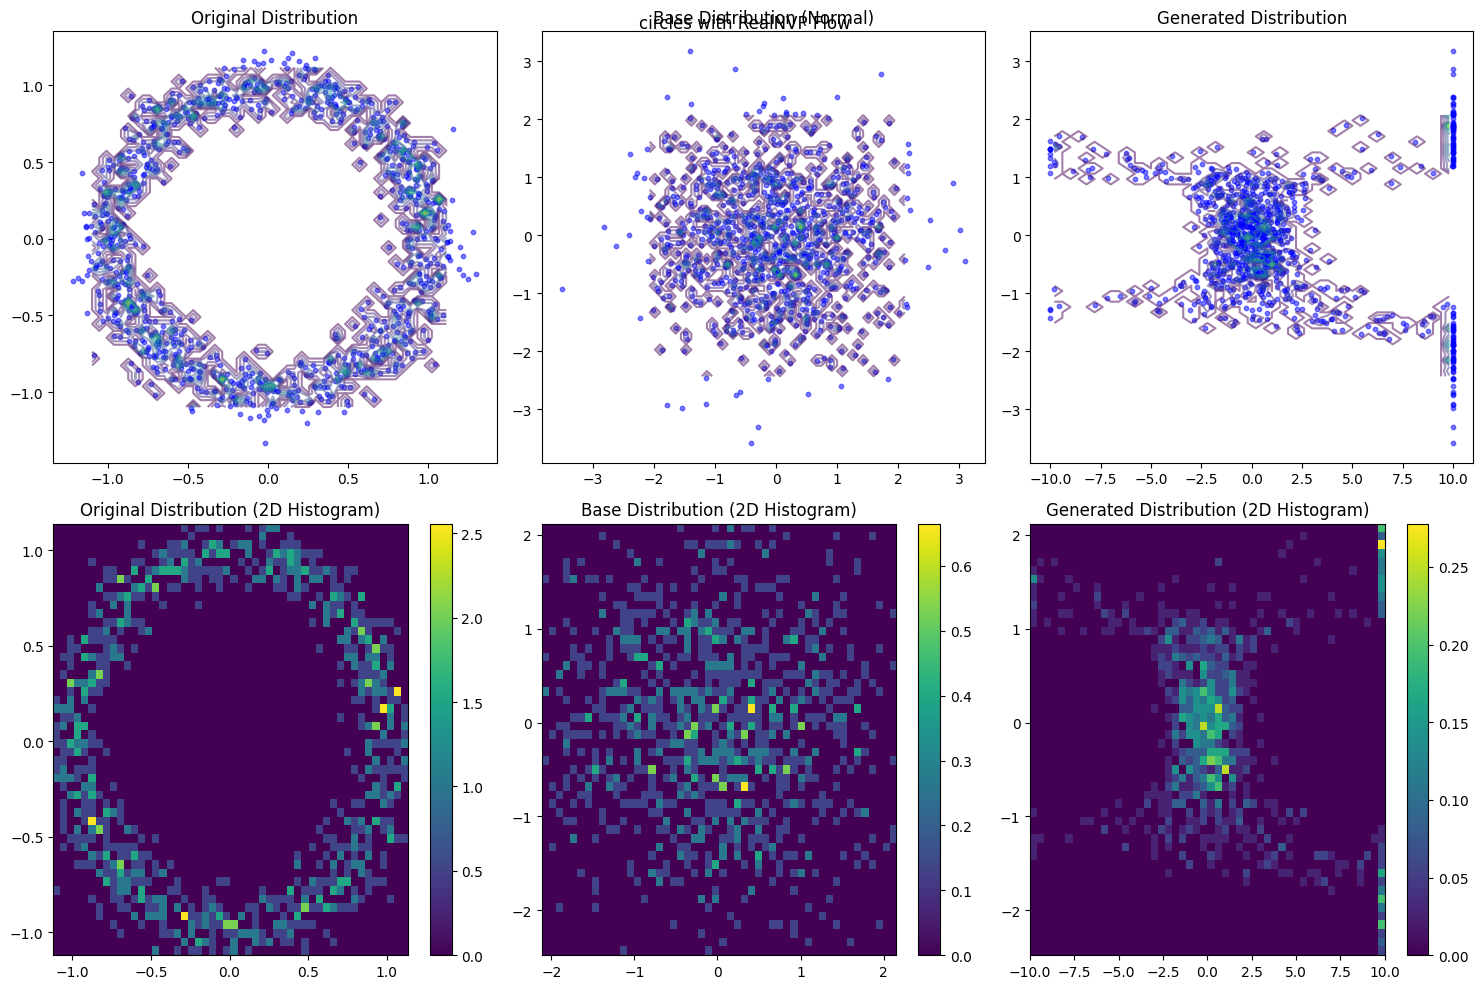

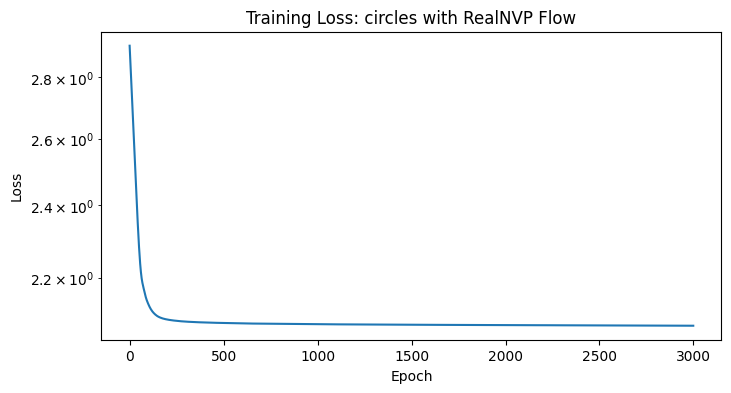


Training MAF architecture...
Epoch 100/3000, Loss: 1.8962
Epoch 200/3000, Loss: 1.8670
Epoch 300/3000, Loss: 1.8504
Epoch 400/3000, Loss: 1.8320
Epoch 500/3000, Loss: 1.8185
Epoch 600/3000, Loss: 1.8084
Epoch 700/3000, Loss: 1.8029
Epoch 800/3000, Loss: 1.7959
Epoch 900/3000, Loss: 1.7888
Epoch 1000/3000, Loss: 1.7835
Epoch 1100/3000, Loss: 1.7803
Epoch 1200/3000, Loss: 1.7775
Epoch 1300/3000, Loss: 1.7752
Epoch 1400/3000, Loss: 1.7737
Epoch 1500/3000, Loss: 1.7728
Epoch 1600/3000, Loss: 1.7713
Epoch 1700/3000, Loss: 1.7702
Epoch 1800/3000, Loss: 1.7691
Epoch 1900/3000, Loss: 1.7708
Epoch 2000/3000, Loss: 1.7682
Epoch 2100/3000, Loss: 1.7679
Epoch 2200/3000, Loss: 1.7671
Epoch 2300/3000, Loss: 1.7668
Epoch 2400/3000, Loss: 1.7663
Epoch 2500/3000, Loss: 1.7660
Epoch 2600/3000, Loss: 1.7655
Epoch 2700/3000, Loss: 1.7650
Epoch 2800/3000, Loss: 1.7644
Epoch 2900/3000, Loss: 1.7642
Epoch 3000/3000, Loss: 1.7640


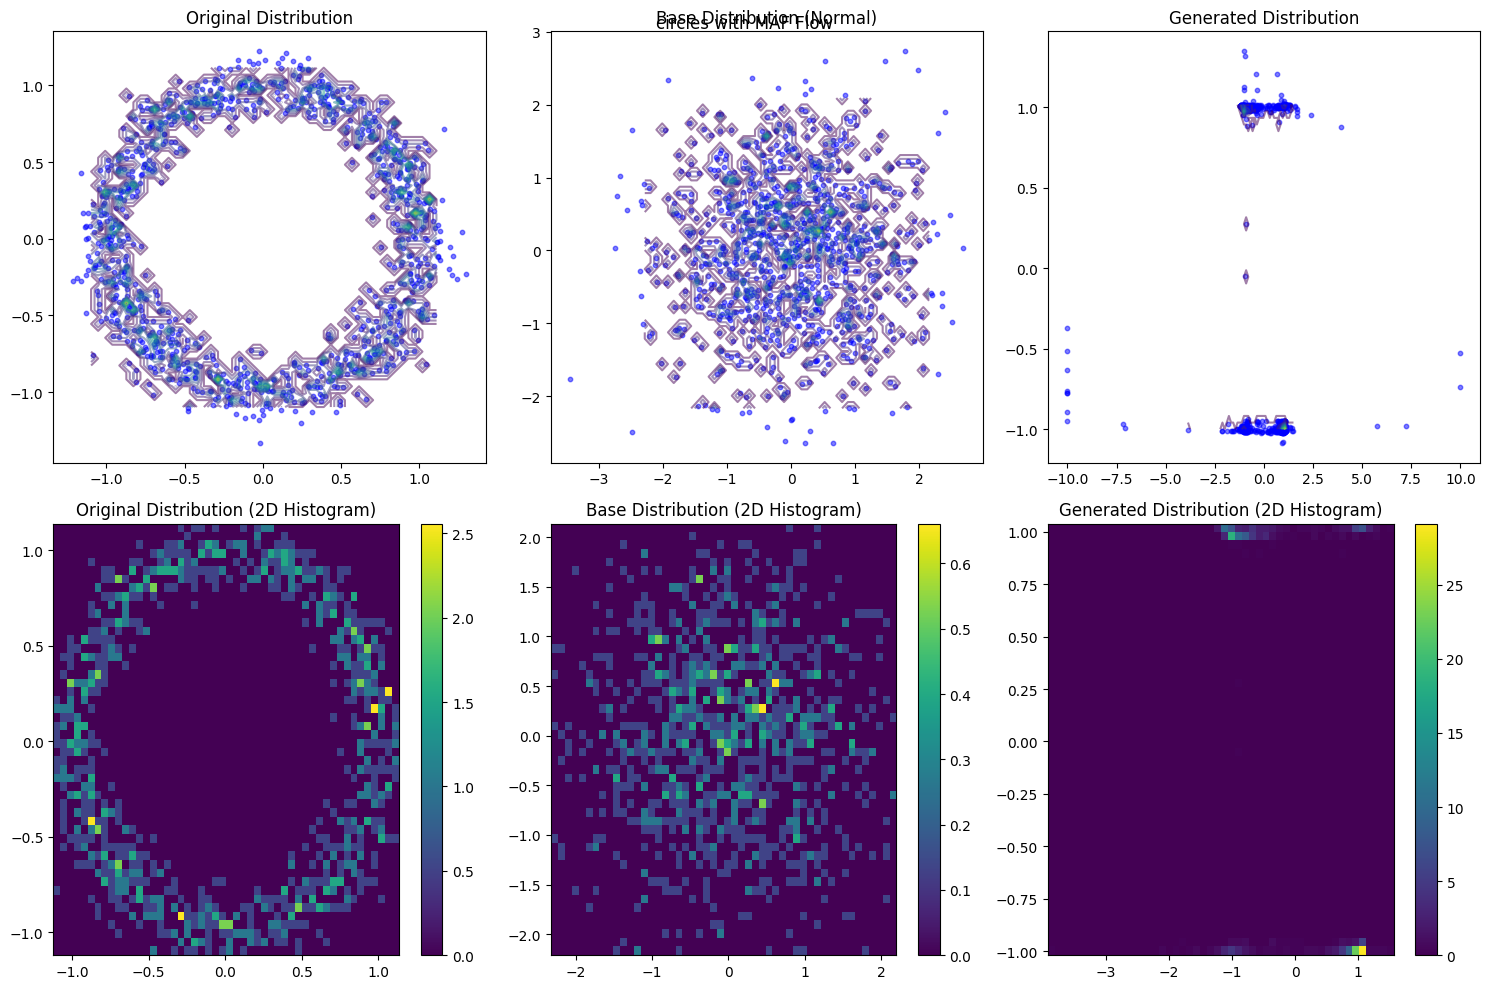

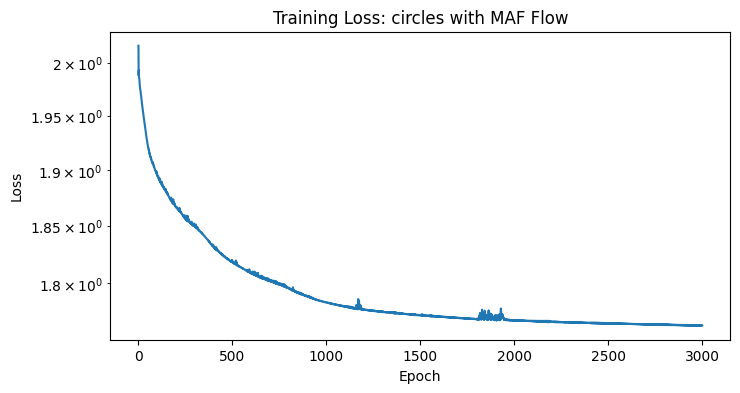


Training Mixed architecture...
Epoch 100/3000, Loss: 0.7702
Epoch 200/3000, Loss: 0.6364
Epoch 300/3000, Loss: 0.5616
Epoch 400/3000, Loss: 0.5037
Epoch 500/3000, Loss: 0.3671
Epoch 600/3000, Loss: 0.2813
Epoch 700/3000, Loss: 0.2516
Epoch 800/3000, Loss: 0.2271
Epoch 900/3000, Loss: 0.2083
Epoch 1000/3000, Loss: 0.1907
Epoch 1100/3000, Loss: 0.1747
Epoch 1200/3000, Loss: 0.1599
Epoch 1300/3000, Loss: 0.1467
Epoch 1400/3000, Loss: 0.1340
Epoch 1500/3000, Loss: 0.1231
Epoch 1600/3000, Loss: 0.1124
Epoch 1700/3000, Loss: 0.1022
Epoch 1800/3000, Loss: 0.0923
Epoch 1900/3000, Loss: 0.0831
Epoch 2000/3000, Loss: 0.0743
Epoch 2100/3000, Loss: 0.0660
Epoch 2200/3000, Loss: 0.0579
Epoch 2300/3000, Loss: 0.0526
Epoch 2400/3000, Loss: 0.0491
Epoch 2500/3000, Loss: 0.0427
Epoch 2600/3000, Loss: 0.0380
Epoch 2700/3000, Loss: 0.0340
Epoch 2800/3000, Loss: 0.0277
Epoch 2900/3000, Loss: 0.0232
Epoch 3000/3000, Loss: 0.0209


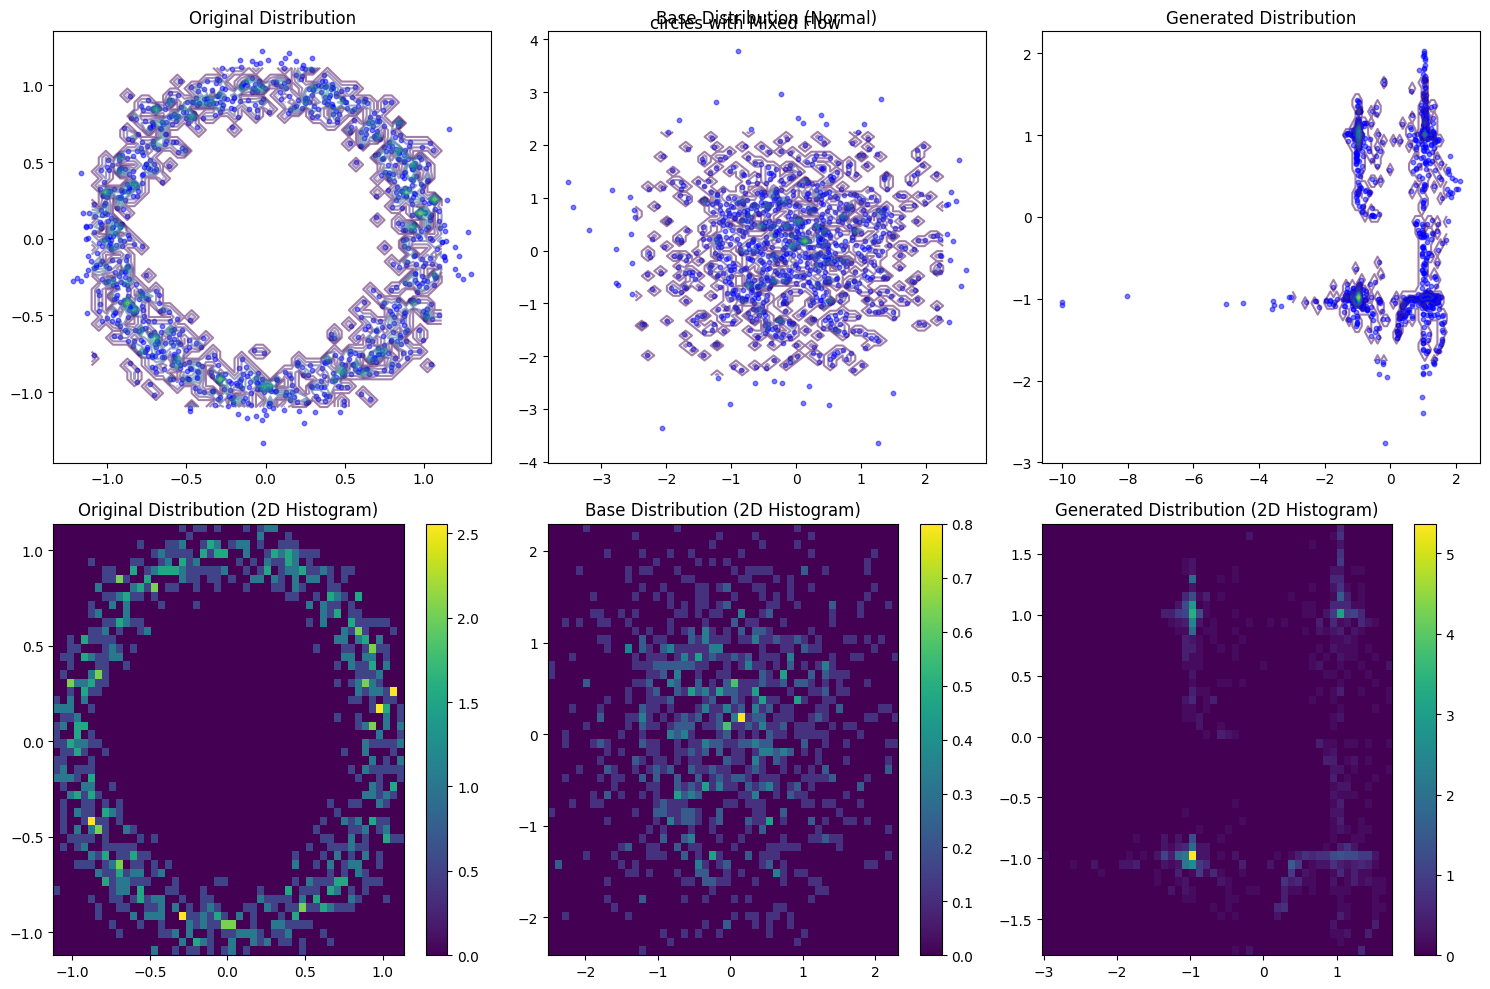

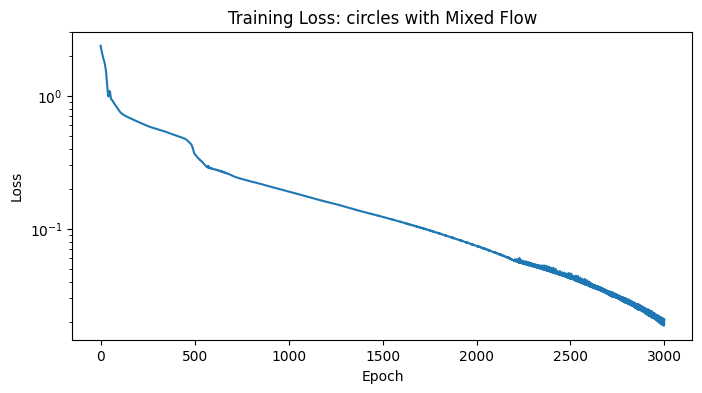


Training on moons dataset:

Training Simple architecture...
Epoch 100/3000, Loss: 3.3478
Epoch 200/3000, Loss: 3.3272
Epoch 300/3000, Loss: 3.3077
Epoch 400/3000, Loss: 3.2889
Epoch 500/3000, Loss: 3.2708
Epoch 600/3000, Loss: 3.2532
Epoch 700/3000, Loss: 3.2359
Epoch 800/3000, Loss: 3.2189
Epoch 900/3000, Loss: 3.2021
Epoch 1000/3000, Loss: 3.1854
Epoch 1100/3000, Loss: 3.1689
Epoch 1200/3000, Loss: 3.1526
Epoch 1300/3000, Loss: 3.1366
Epoch 1400/3000, Loss: 3.1209
Epoch 1500/3000, Loss: 3.1057
Epoch 1600/3000, Loss: 3.0909
Epoch 1700/3000, Loss: 3.0768
Epoch 1800/3000, Loss: 3.0632
Epoch 1900/3000, Loss: 3.0503
Epoch 2000/3000, Loss: 3.0381
Epoch 2100/3000, Loss: 3.0267
Epoch 2200/3000, Loss: 3.0159
Epoch 2300/3000, Loss: 3.0058
Epoch 2400/3000, Loss: 2.9963
Epoch 2500/3000, Loss: 2.9874
Epoch 2600/3000, Loss: 2.9790
Epoch 2700/3000, Loss: 2.9710
Epoch 2800/3000, Loss: 2.9634
Epoch 2900/3000, Loss: 2.9562
Epoch 3000/3000, Loss: 2.9494


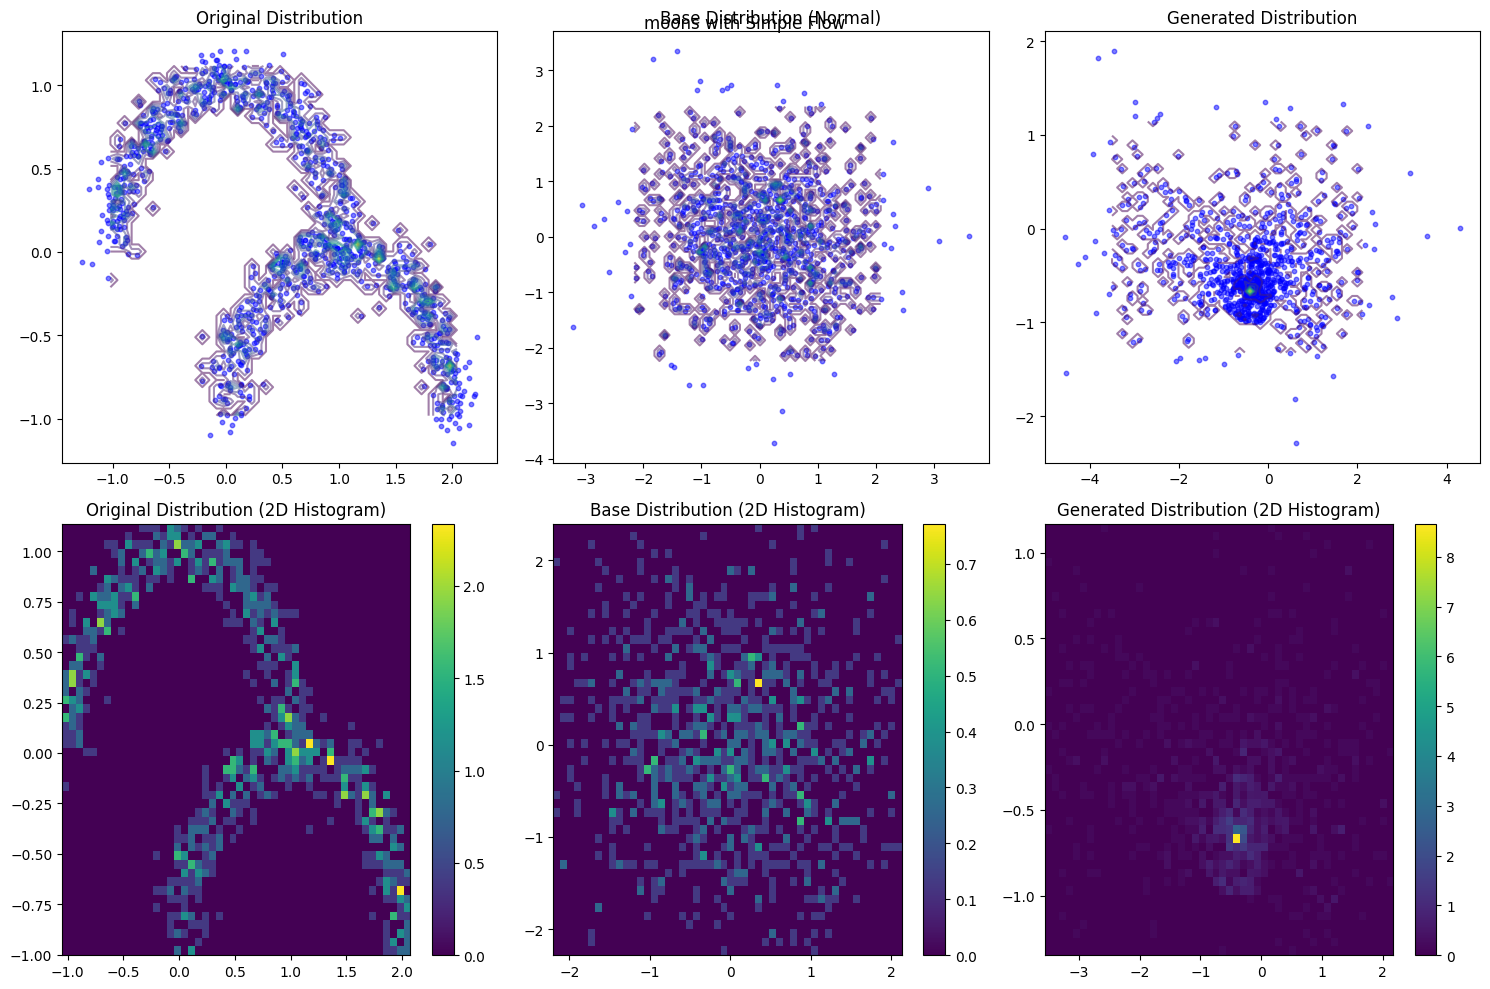

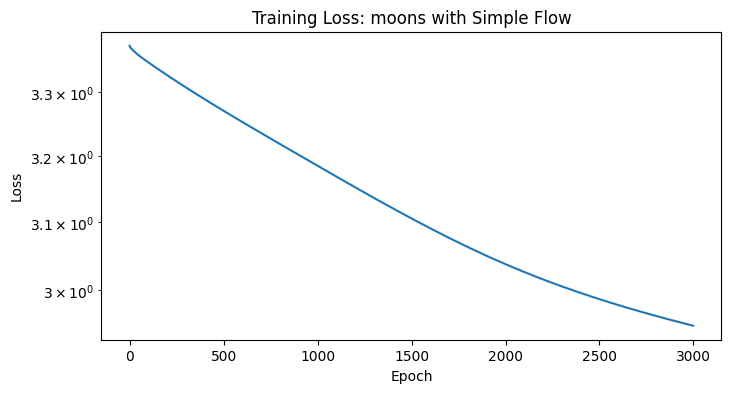


Training RealNVP architecture...
Epoch 100/3000, Loss: 2.1431
Epoch 200/3000, Loss: 2.1135
Epoch 300/3000, Loss: 2.1023
Epoch 400/3000, Loss: 2.0967
Epoch 500/3000, Loss: 2.0933
Epoch 600/3000, Loss: 2.0913
Epoch 700/3000, Loss: 2.0899
Epoch 800/3000, Loss: 2.0888
Epoch 900/3000, Loss: 2.0879
Epoch 1000/3000, Loss: 2.0871
Epoch 1100/3000, Loss: 2.0865
Epoch 1200/3000, Loss: 2.0859
Epoch 1300/3000, Loss: 2.0855
Epoch 1400/3000, Loss: 2.0850
Epoch 1500/3000, Loss: 2.0846
Epoch 1600/3000, Loss: 2.0842
Epoch 1700/3000, Loss: 2.0838
Epoch 1800/3000, Loss: 2.0835
Epoch 1900/3000, Loss: 2.0831
Epoch 2000/3000, Loss: 2.0829
Epoch 2100/3000, Loss: 2.0826
Epoch 2200/3000, Loss: 2.0822
Epoch 2300/3000, Loss: 2.0820
Epoch 2400/3000, Loss: 2.0817
Epoch 2500/3000, Loss: 2.0814
Epoch 2600/3000, Loss: 2.0811
Epoch 2700/3000, Loss: 2.0808
Epoch 2800/3000, Loss: 2.0806
Epoch 2900/3000, Loss: 2.0803
Epoch 3000/3000, Loss: 2.0800


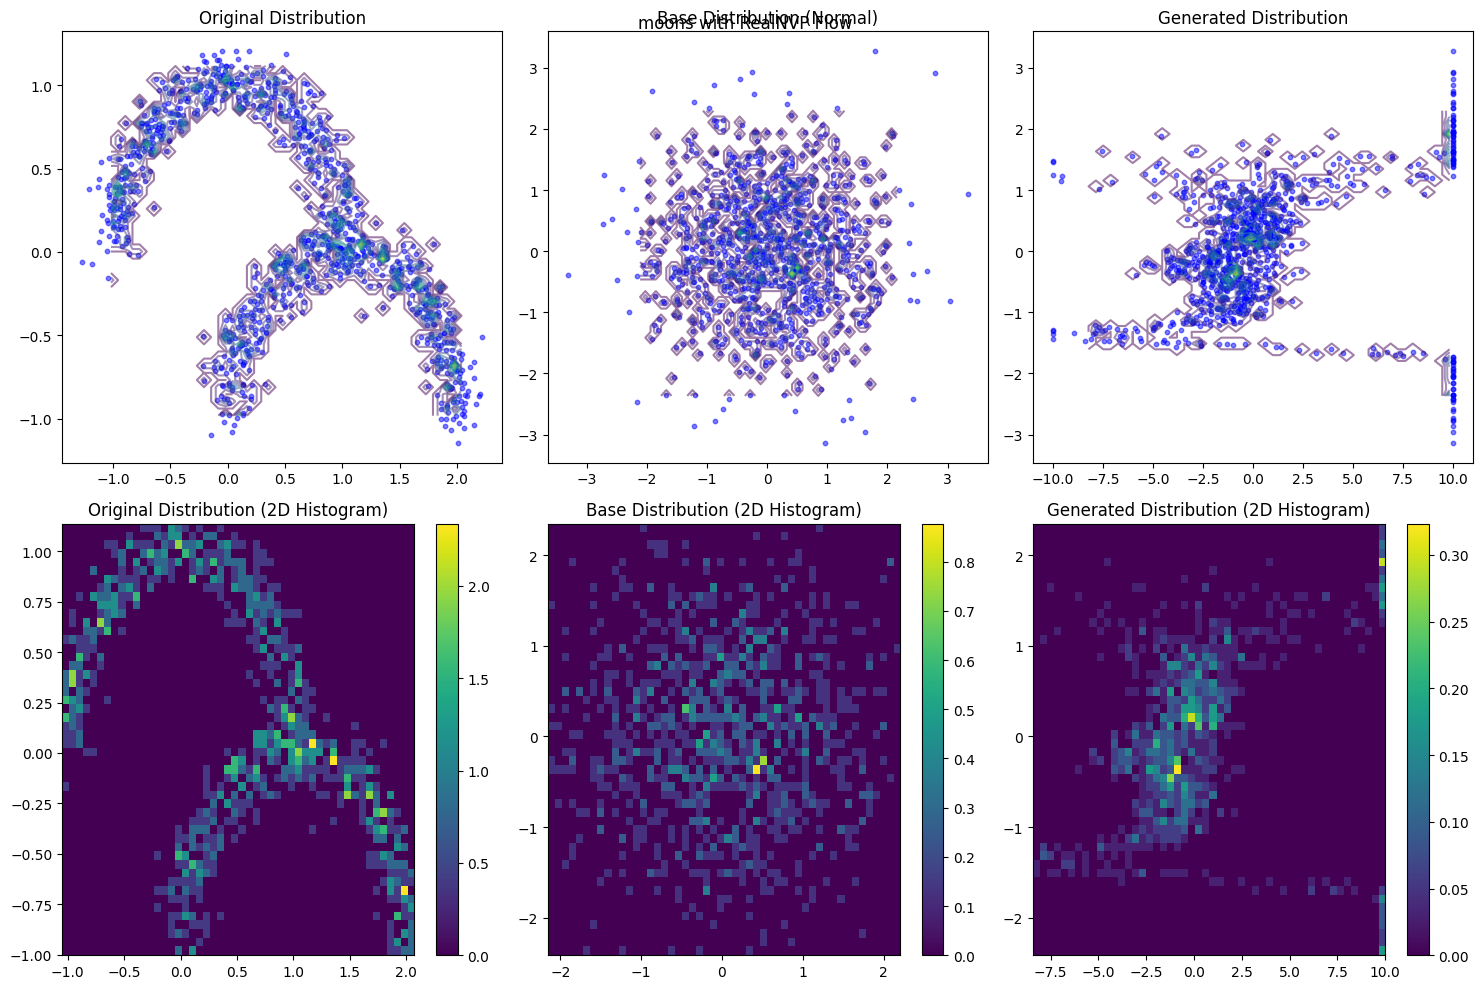

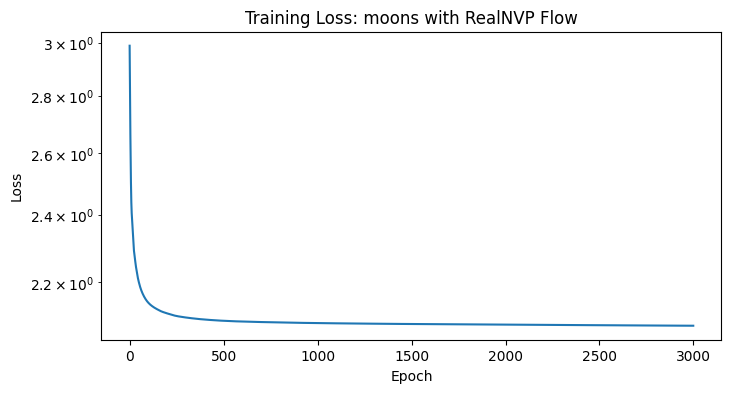


Training MAF architecture...
Epoch 100/3000, Loss: 2.2233
Epoch 200/3000, Loss: 2.2173
Epoch 300/3000, Loss: 2.2138
Epoch 400/3000, Loss: 2.2112
Epoch 500/3000, Loss: 2.2084
Epoch 600/3000, Loss: 2.2070
Epoch 700/3000, Loss: 2.2048
Epoch 800/3000, Loss: 2.2030
Epoch 900/3000, Loss: 2.2016
Epoch 1000/3000, Loss: 2.2004
Epoch 1100/3000, Loss: 2.1995
Epoch 1200/3000, Loss: 2.1989
Epoch 1300/3000, Loss: 2.1980
Epoch 1400/3000, Loss: 2.1975
Epoch 1500/3000, Loss: 2.1967
Epoch 1600/3000, Loss: 2.1970
Epoch 1700/3000, Loss: 2.1964
Epoch 1800/3000, Loss: 2.1961
Epoch 1900/3000, Loss: 2.1955
Epoch 2000/3000, Loss: 2.1954
Epoch 2100/3000, Loss: 2.1950
Epoch 2200/3000, Loss: 2.1952
Epoch 2300/3000, Loss: 2.1948
Epoch 2400/3000, Loss: 2.1944
Epoch 2500/3000, Loss: 2.1947
Epoch 2600/3000, Loss: 2.1943
Epoch 2700/3000, Loss: 2.1944
Epoch 2800/3000, Loss: 2.1943
Epoch 2900/3000, Loss: 2.1938
Epoch 3000/3000, Loss: 2.1941


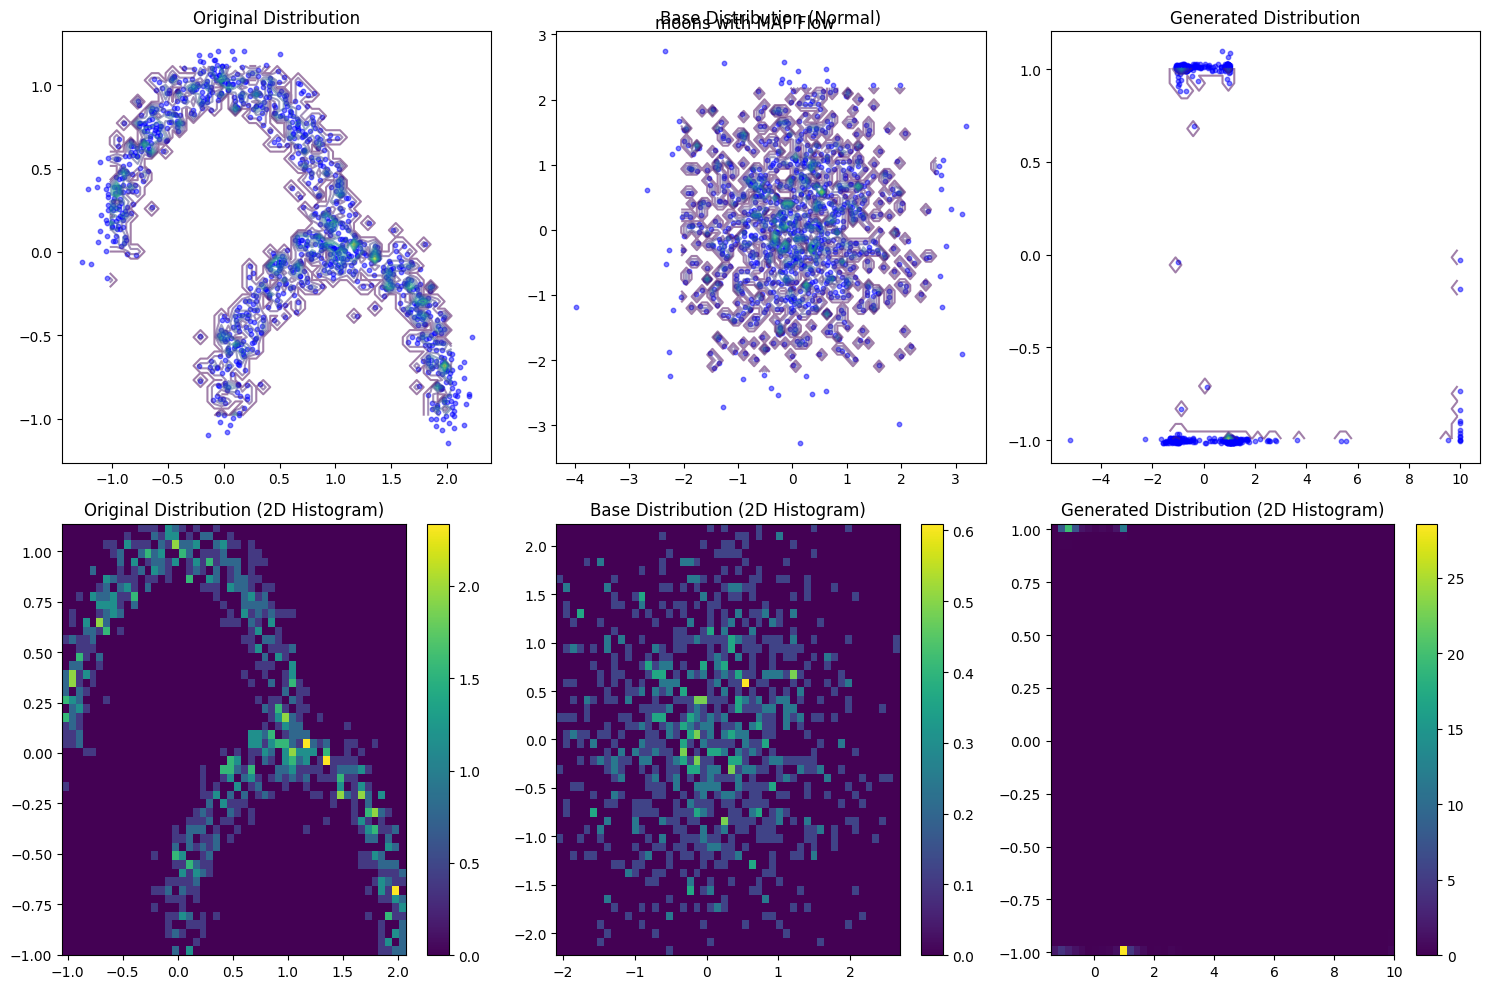

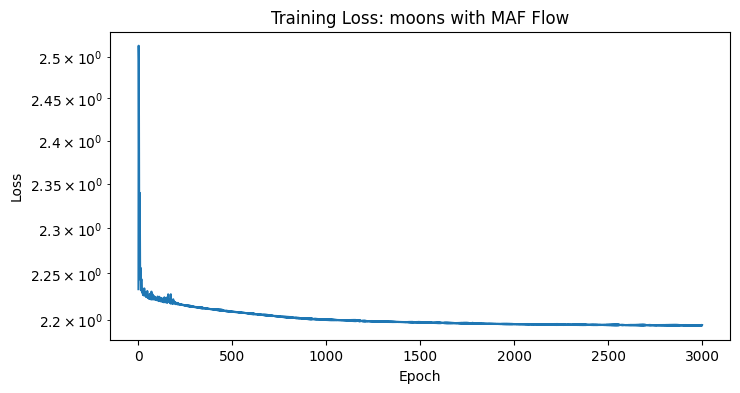


Training Mixed architecture...
Epoch 100/3000, Loss: 0.4352
Epoch 200/3000, Loss: 0.2926
Epoch 300/3000, Loss: 0.2427
Epoch 400/3000, Loss: 0.2213
Epoch 500/3000, Loss: 0.2050
Epoch 600/3000, Loss: 0.1892
Epoch 700/3000, Loss: 0.1748
Epoch 800/3000, Loss: 0.1600
Epoch 900/3000, Loss: 0.1419
Epoch 1000/3000, Loss: 0.1275
Epoch 1100/3000, Loss: 0.1140
Epoch 1200/3000, Loss: 0.1028
Epoch 1300/3000, Loss: 0.0927
Epoch 1400/3000, Loss: 0.0824
Epoch 1500/3000, Loss: 0.0696
Epoch 1600/3000, Loss: 0.0564
Epoch 1700/3000, Loss: 0.0424
Epoch 1800/3000, Loss: 0.0297
Epoch 1900/3000, Loss: 0.0166
Epoch 2000/3000, Loss: 0.0024
Epoch 2100/3000, Loss: -0.0129
Epoch 2200/3000, Loss: -0.0345
Epoch 2300/3000, Loss: -0.0555
Epoch 2400/3000, Loss: -0.0695
Epoch 2500/3000, Loss: -0.0826
Epoch 2600/3000, Loss: -0.0957
Epoch 2700/3000, Loss: -0.1105
Epoch 2800/3000, Loss: -0.1299
Epoch 2900/3000, Loss: -0.1853
Epoch 3000/3000, Loss: -0.1640


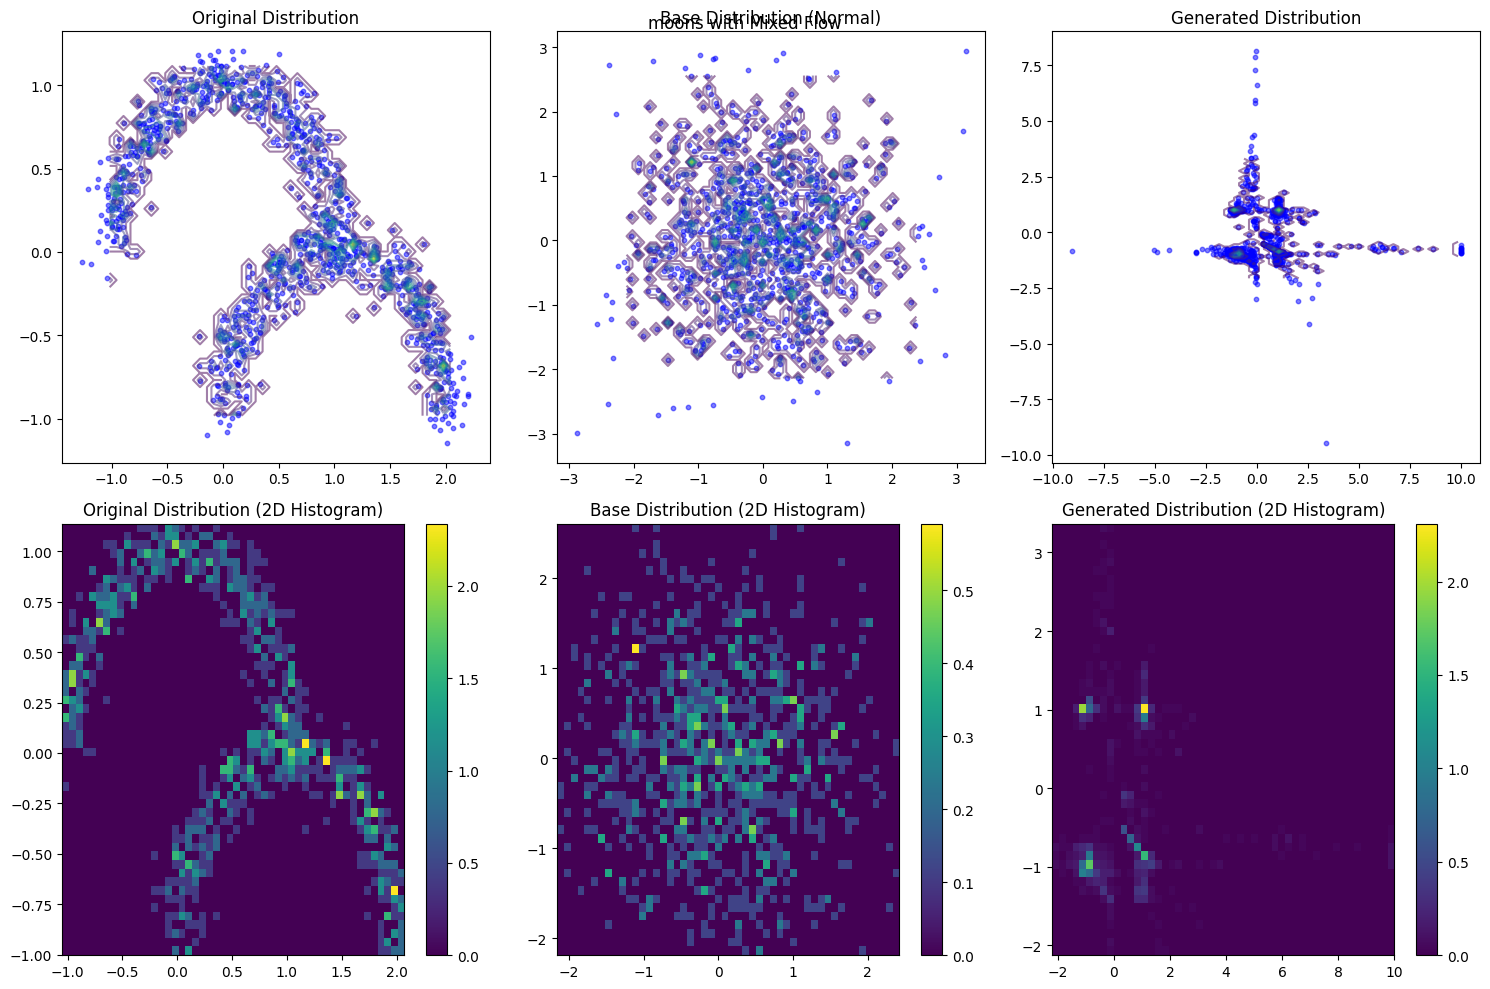

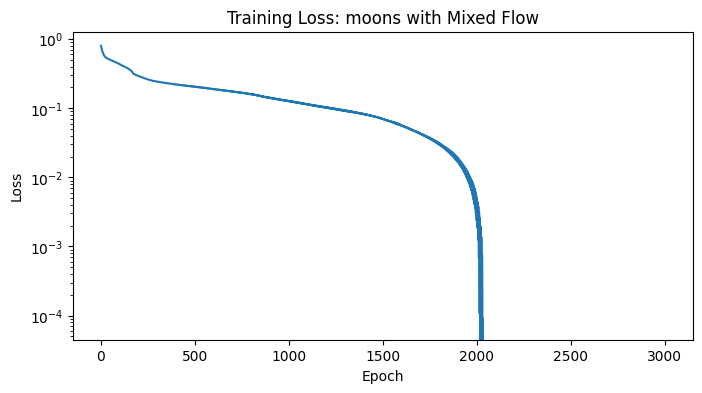

In [56]:
def main():
    # Generate toy datasets
    datasets = {
        'two_gaussians': create_toy_dataset(1000, 'two_gaussians'),
        'circles': create_toy_dataset(1000, 'circles'),
        'moons': create_toy_dataset(1000, 'moons')
    }
    
    # Create different flow models
    dim = 2
    flow_architectures = {
        'Simple': [
            PlanarFlow(dim),
            RadialFlow(dim),
            PlanarFlow(dim)
        ],
        'RealNVP': [
            RealNVPCoupling(dim),
            RealNVPCoupling(dim, mask_type='alternate'),
            RealNVPCoupling(dim, mask_type='half')
        ],
        'MAF': [
            MAF(dim),
            MAF(dim),
            MAF(dim)
        ],
        'Mixed': [
            PlanarFlow(dim),
            RealNVPCoupling(dim),
            MAF(dim)
        ]
    }
    
    # Train and visualize each combination
    for dataset_name, data in datasets.items():
        print(f"\nTraining on {dataset_name} dataset:")
        for arch_name, flows in flow_architectures.items():
            print(f"\nTraining {arch_name} architecture...")
            
            # Initialize flow model
            flow_model = NormalizingFlow(flows)
            
            # Train with lower learning rate for stability
            trained_flow, losses = train_flow(flow_model, data, n_epochs=3000, lr=1e-4)
            
            # Visualize
            fig = visualize_flow(trained_flow, data)
            plt.suptitle(f'{dataset_name} with {arch_name} Flow')
            plt.show()
            
            # Plot loss curve
            plt.figure(figsize=(8, 4))
            plt.plot(losses)
            plt.title(f'Training Loss: {dataset_name} with {arch_name} Flow')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.yscale('log')
            plt.show()

if __name__ == "__main__":
    main()